# Analyzing Sea Level Rise in the Cloud with Coiled and Earthaccess

_This notebook was adapted from [this NASA Earthdata Cloud Cookbook example](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/external/Sea_level_rise_notebook.html)_

## Create cluster on AWS with Coiled

In [1]:
%%time

# Spin up a Coiled cluster in the same region as our data (us-west-2)
import coiled

cluster = coiled.Cluster(n_workers=20, region="us-west-2")
client = cluster.get_client()
client

Output()

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                         ╷                                                                        │
│   Package               │ Note                                                                   │
│ ╶───────────────────────┼──────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_examples │ Source wheel built from /Users/james/projects/coiled/examples          │
│   earthaccess           │ Wheel built from                                                       │
│                         │ git+https://github.com/jrbourbeau/earthaccess.git@d86e470ab019a7081c   │
│                         │ 2053108e3f0402f57553c7                                                 │
│                         ╵                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

CPU times: user 7.7 s, sys: 592 ms, total: 8.29 s
Wall time: 1min 41s


<Client: 'tls://10.0.59.218:8786' processes=13 threads=52, memory=192.93 GiB>

## Get data files with `earthaccess`

In [2]:
# Authenticate my machine with `earthaccess`
import earthaccess

earthaccess.login();

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/01/2023
Using .netrc file for EDL


In [3]:
%%time

# Retrieve data files for the dataset I'm interested in
short_name = "SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205"
results = earthaccess.search_data(
    short_name=short_name,
    cloud_hosted=True,
    temporal=("1990", "2019"),
    # bounding_box=...,
)

Granules found: 1916
CPU times: user 566 ms, sys: 69.2 ms, total: 636 ms
Wall time: 1min 2s


## Analyze data on my cluster with Xarray

In [4]:
# %%time

# import xarray as xr

# ds = xr.open_mfdataset(earthaccess.open(results))
# ds

In [5]:
%%time

fs = earthaccess.get_s3fs_session(daac="PODAAC")

CPU times: user 109 ms, sys: 14.5 ms, total: 124 ms
Wall time: 3.51 s


In [6]:
%%time

import xarray as xr

ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "fo": f"s3://oss-shared-scratch/jrbourbeau/{short_name}/combined.json",
            "remote_protocol": "s3",
            "remote_options": fs.storage_options,
        }
    },
)
ds

CPU times: user 629 ms, sys: 172 ms, total: 801 ms
Wall time: 7.67 s


<xarray.Dataset>
Dimensions:      (Time: 1916, Latitude: 960, nv: 2, Longitude: 2160)
Coordinates:
  * Latitude     (Latitude) float32 0.0 0.0 1.689e-38 ... -3.124e+13 -29.8
  * Longitude    (Longitude) float32 0.0 0.0 1.735e+23 ... 1.187e+27 2.147e+29
  * Time         (Time) datetime64[ns] 1992-10-10T12:00:00 ... 2018-12-28T12:...
Dimensions without coordinates: nv
Data variables:
    Lat_bounds   (Time, Latitude, nv) float32 dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Lon_bounds   (Time, Longitude, nv) float32 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    SLA          (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
    SLA_ERR      (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
    Time_bounds  (Time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    DOI:                    10.5067/SLREF-CDRV3
    Data_Pnts_Each_Sat:     {"16": 661578, "1001": 636257}
    Institution:            Jet Propulsion Laboratory
    SLA_Global_MEAN:        -0.0015108844021796562
    SLA_Global_STD:         0.09098986023297456
    ...                     ...
    source_version:         commit dc95db885c920084614a41849ce5a7d417198ef3
    summary:                Sea level anomaly grids from altimeter data using...
    time_coverage_end:      1992-10-10
    time_coverage_start:    1992-10-10
    title:                  Sea Level Anomaly Estimate based on Altimeter Dat...
    version_number:         2205

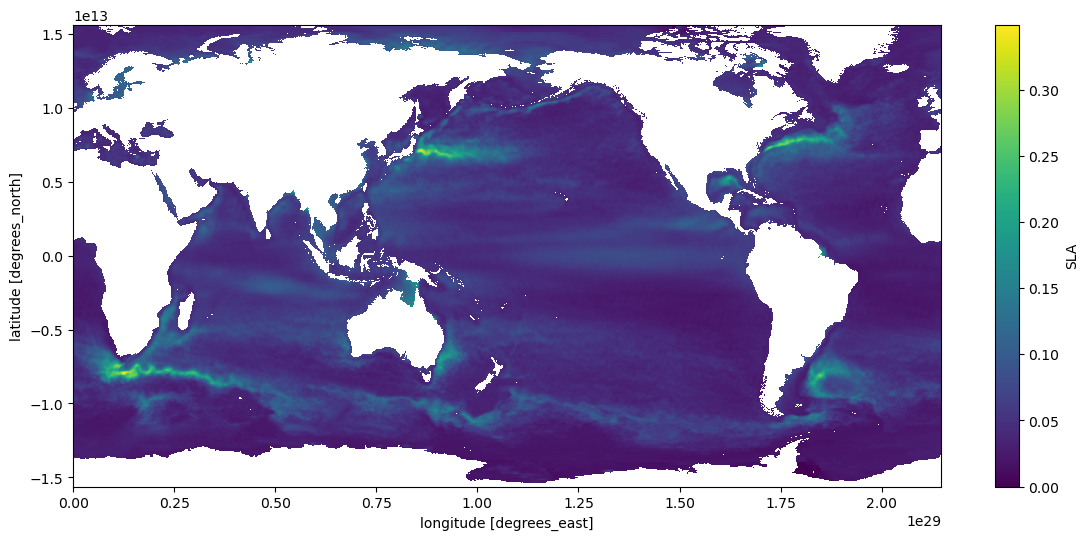

In [30]:
ds.SLA.where((ds.SLA>=0) & (ds.SLA < 10)).std("Time")[::-1, :].plot.imshow(figsize=(14, 6));